In [1]:
import csv
import requests

# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
CSV_URL = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol=IBM&interval=15min&slice=year1month1&apikey=4KRSSGN8IWNU8IBV'

with requests.Session() as s:
    download = s.get(CSV_URL)
    decoded_content = download.content.decode('utf-8')
    cr = csv.reader(decoded_content.splitlines(), delimiter=',')
    my_list = list(cr)
    csv_file= open('/home/amit/data.csv', 'w')
    csv_writer = csv.writer(csv_file, delimiter=",")
    for row in my_list:
        csv_writer.writerow(row)

In [2]:
df=spark.read.csv("file:///home/amit/data.csv",header=True,inferSchema=True)

In [3]:
def split(x):
    temp=x.split()
    return temp[0]

from pyspark.sql.functions import udf,col
from pyspark.sql.types import StringType

new_split = udf(lambda x:split(x),StringType())

In [4]:
from pyspark.sql.functions import lower, col
df = df.withColumn("Date",new_split(col("time")))

In [5]:
df.createOrReplaceTempView("table")

In [6]:
df=spark.sql("SELECT Date,FIRST(open) as open,MAX(high) as high,MIN(low) as low,LAST(close) as close,MAX(volume) as volume from table GROUP BY Date ORDER BY Date")

In [7]:
df.show()

+----------+------+--------+--------+------+-------+
|      Date|  open|    high|     low| close| volume|
+----------+------+--------+--------+------+-------+
|2021-12-29| 133.0|  134.21|   132.3| 132.5| 342721|
|2021-12-30|133.83|  134.37|  133.02|133.41| 446147|
|2021-12-31|133.69|  134.99|  133.46|133.88| 436471|
|2022-01-03|135.77| 136.295|  133.61| 133.8| 420316|
|2022-01-04| 137.8|  139.95|   135.9|136.41| 581760|
|2022-01-05|138.09|   142.2|  137.25|137.96| 999384|
|2022-01-06|135.45|138.4099|  132.51| 137.6| 932284|
|2022-01-07|134.83|135.6618|133.5111|135.07| 638345|
|2022-01-10|135.03|   136.2|  133.38| 135.1| 563951|
|2022-01-11| 132.8|  133.72|  127.97| 132.9|2168991|
|2022-01-12| 133.4|  134.47|  131.37| 132.7| 497902|
|2022-01-13| 134.6|  136.05| 133.377|133.66| 581846|
|2022-01-14|134.22|  135.14|   133.3|134.54| 468711|
|2022-01-18|132.71|   134.0|  131.78|133.37| 564555|
|2022-01-19|131.01|   133.9|  131.01|132.65| 483940|
|2022-01-20|130.79|  132.88|   130.2|131.45| 6

In [8]:
from pyspark.sql.functions import lead,col
from pyspark.sql.window import Window

In [9]:
window=Window.orderBy("Date")

In [10]:
a= lead(col("open")).over(window)

In [11]:
final_df = df.withColumn("next_open",a).dropna(how="any")

In [12]:
final_df.show()

2022-01-22 18:39:47,223 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2022-01-22 18:39:47,226 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2022-01-22 18:39:47,377 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2022-01-22 18:39:47,513 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2022-01-22 18:39:47,602 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+----------+------+--------+--------+------+-------+---------+
|      Date|  open|    high|     low| close| volume|next_open|
+----------+------+--------+--------+------+-------+---------+
|2021-12-29| 133.0|  134.21|   132.3| 132.5| 342721|   133.83|
|2021-12-30|133.83|  134.37|  133.02|133.41| 446147|   133.69|
|2021-12-31|133.69|  134.99|  133.46|133.88| 436471|   135.77|
|2022-01-03|135.77| 136.295|  133.61| 133.8| 420316|    137.8|
|2022-01-04| 137.8|  139.95|   135.9|136.41| 581760|   138.09|
|2022-01-05|138.09|   142.2|  137.25|137.96| 999384|   135.45|
|2022-01-06|135.45|138.4099|  132.51| 137.6| 932284|   134.83|
|2022-01-07|134.83|135.6618|133.5111|135.07| 638345|   135.03|
|2022-01-10|135.03|   136.2|  133.38| 135.1| 563951|    132.8|
|2022-01-11| 132.8|  133.72|  127.97| 132.9|2168991|    133.4|
|2022-01-12| 133.4|  134.47|  131.37| 132.7| 497902|    134.6|
|2022-01-13| 134.6|  136.05| 133.377|133.66| 581846|   134.22|
|2022-01-14|134.22|  135.14|   133.3|134.54| 468711|   

In [21]:
import numpy as np
import pandas as pd                   
import matplotlib.pyplot as plt       
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

In [15]:
feature = VectorAssembler(inputCols=['open','high','low','close','volume'],outputCol='features')

In [16]:
final_data  = feature.transform(final_df)

In [ ]:
final_data.show()

In [33]:
final_data = final_data.select('features','next_open')

In [61]:
train,test = final_data.randomSplit([0.6,0.4])

In [ ]:
regressor = LinearRegression(featuresCol = 'features', labelCol = 'next_open')
regressor = regressor.fit(train)

In [63]:
predictions = regressor.transform(test)
predictions.show()

+--------------------+---------+------------------+
|            features|next_open|        prediction|
+--------------------+---------+------------------+
|[131.01,133.9,131...|   130.79|129.65885819000454|
|[132.71,134.0,131...|   131.01|132.23088710824265|
|[133.0,134.21,132...|   133.83|  133.247083909167|
|[133.83,134.37,13...|   133.69| 134.0594596608663|
|[134.6,136.05,133...|   134.22|135.12616379701643|
|[138.09,142.2,137...|   135.45|137.61432364976457|
+--------------------+---------+------------------+



2022-01-22 18:48:22,739 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2022-01-22 18:48:22,739 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2022-01-22 18:48:22,822 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2022-01-22 18:48:22,864 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2022-01-22 18:48:22,881 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [64]:
regressor.coefficients

DenseVector([1.8831, -0.0843, -0.1883, -0.6513, -0.0])

In [65]:
regressor.intercept

5.336314294318663

In [ ]:
results=regressor.evaluate(test)

In [75]:
print("Root Mean Squared Error (RMSE) on test data = %g" % results.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 1.20774


In [ ]:
panda_df = predictions.toPandas()

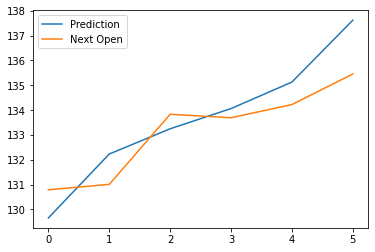

In [76]:
plt.plot(panda_df['prediction'])
plt.plot(panda_df['next_open'])
plt.legend(['Prediction','Next Open'])

In [ ]:
predictions.select("next_open","prediction").write.format("json").save("file:///home/amit/output")